In [1]:
import pandas as pd
import numpy as np
import pysal
import itertools

In [75]:
word_counts = pd.read_csv('subdivision_to_word_counts.tsv', sep='\t', header = None, names = ["id","words"])

In [15]:
neighbors = pd.read_csv('subdivision-to-neighbors.tsv', sep='\t', header = None, names = ["CSDUID", "neighbors"])

In [62]:
neighbors["nn"] = [str.split(neighbors.neighbors[i]) for i in range(neighbors.shape[0])]

In [96]:
str_csduid = [str(x) for x in neighbors.CSDUID]
df_reg = pd.DataFrame(np.zeros((4240,4240)), columns=str_csduid,index=str_csduid)

In [97]:
for i in range(4240):
    df_reg.loc[str_csduid[i], neighbors.nn[i]] = 1 

In [114]:
word_counts.head()

,id,words,word,counts
0,5915022,by 10610 david 212 featuring 786 is 18567 in 2...,"[by, david, featuring, is, in, vera, on, the, ...","[10610, 212, 786, 18567, 24940, 6909, 17058, 4..."
1,5919008,pst 2105 wind 2604 mph 2604 barometer 2604 in ...,"[pst, wind, mph, barometer, in, steady, temper...","[2105, 2604, 2604, 2604, 5402, 964, 2604, 2106..."
2,3520005,nba 319 made 3500 a 97237 big 3546 mistake 253...,"[nba, made, a, big, mistake, by, making, the, ...","[319, 3500, 97237, 3546, 253, 10414, 2059, 152..."
3,4611040,i 24551 mean 411 doing 529 that 7714 against 1...,"[i, mean, doing, that, against, this, warriors...","[24551, 411, 529, 7714, 176, 6678, 16, 631, 20..."
4,3539036,min 27 phone 171 call 191 with 2517 pizza 97 t...,"[min, phone, call, with, pizza, to, order, med...","[27, 171, 191, 2517, 97, 8880, 39, 8, 88, 9939..."


In [79]:
word_counts_splt = [str.split(word_counts.words[i]) for i in range(word_counts.shape[0])]

In [85]:
words = []
counts = []
for i in range(word_counts.shape[0]):
    wc_lst = word_counts_splt[i]
    words.append([wc_lst[i] for i in range(len(wc_lst)) if i % 2 == 0])
    counts.append([wc_lst[i] for i in range(len(wc_lst)) if i % 2 != 0])

In [109]:
word_counts["word"] = words
word_counts["counts"] = counts

In [89]:
unique_words = set(sum(words, []))

In [267]:
str_id = [str(x) for x in word_counts.id]
df_wc = pd.DataFrame(np.zeros((4240,10000)), columns=unique_words,index=str_csduid)
df_wc = df_wc.reindex_axis(sorted(df_wc.columns), axis=1)

In [270]:
%%time
for i in range(4224):
    wd = word_counts.word[i]
    for w in wd:
        df_wc.loc[str_id[i], w] = eval(word_counts.counts[i][word_counts.word[i].index(w)]) 

CPU times: user 8min 34s, sys: 3.42 s, total: 8min 37s
Wall time: 8min 47s


In [417]:
#import pickle
#pickle.dump(df_wc, open("region_word_count.pkl", "wb"))
#df_wc = pickle.load(open("region_word_count.pkl", "rb"))

In [214]:
#extra_ind = [x for x in str_csduid if x not in str_id]
#df_extra = pd.DataFrame(np.zeros((16,10000)), columns=unique_words,index=extra_ind)
#df_wc = pd.concat([df_wc, df_extra])

In [221]:
#db = pysal.weights.Distance.DistanceBand.from_dataframe(df_reg, threshold = 1000, geom_col = str_csduid)

In [ ]:
dict_df = neighbors.loc[:,["nn"]]
dict_df["str_csduid"] = str_csduid
dict_w = dict_df.set_index("str_csduid").to_dict()["nn"]
weight = pysal.weights.weights.W(dict_w)

In [361]:
from pysal.esda.getisord import G_Local
np.random.seed(12345)
y = df_wc.atlantic.astype("float64").values
dist_w = weight
lg_atlantic = G_Local(y, dist_w, star = True)

In [363]:
df_output = pd.DataFrame(np.zeros((4240, 2)), columns=["CSDUID","color_value"],index=df_wc.index)
df_output["CSDUID"] = df_wc.index
df_output["color_value"] = lg_atlantic.Zs

In [367]:
df_output.color_value.describe()

count    4240.000000
mean       -0.001606
std         0.036035
min        -0.050014
25%        -0.034979
50%        -0.011170
75%         0.035620
max         0.352520
Name: color_value, dtype: float64

In [161]:
example = pd.read_csv('random-subdivision-values.tsv', sep='\t')

## Plot

In [284]:
%matplotlib inline
import geopandas as gpd
import matplotlib.pyplot as plt

In [368]:
canada_df = gpd.GeoDataFrame.from_file("gcsd000b11a_e.shp")
canada_df = canada_df.merge(df_output, on='CSDUID')

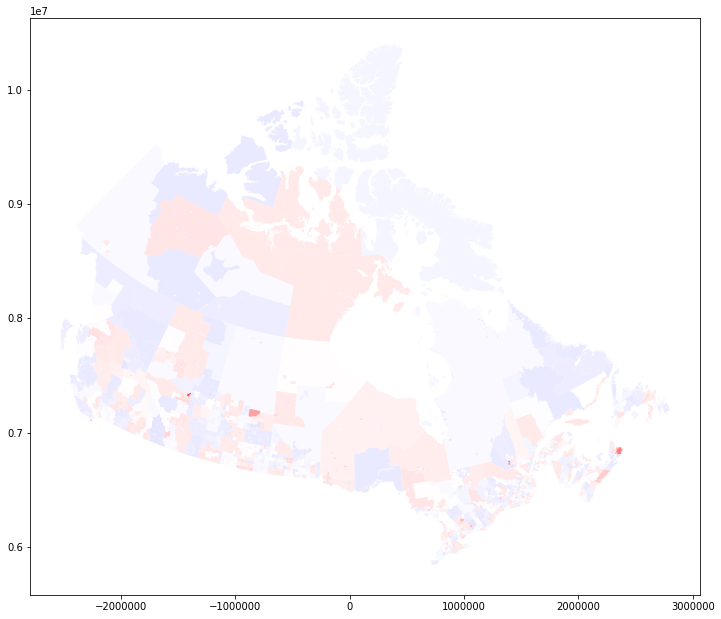

In [370]:
g = canada_df.to_crs('+proj=lcc +lat_1=49 +lat_2=77 +lon_0=-91.52 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"').plot(column='color_value', vmin=-1, vmax=1, cmap='seismic', figsize=(12, 12))

In [377]:
def plot_map(word):
    y = df_wc[word].astype("float64").values
    dist_w = weight
    lg = G_Local(y, dist_w, star = True)
    df_output = pd.DataFrame(np.zeros((4240, 2)), columns=["CSDUID","color_value"],index=df_wc.index)
    df_output["CSDUID"] = df_wc.index
    df_output["color_value"] = lg.Zs
    canada_df = gpd.GeoDataFrame.from_file("gcsd000b11a_e.shp")
    canada_df = canada_df.merge(df_output, on='CSDUID')
    
    return([df_output,canada_df])

In [378]:
alaska = plot_map("alaska")

In [379]:
alaska[0].color_value.describe()

count    4240.000000
mean       -0.003264
std         0.057235
min        -0.051591
25%        -0.029602
50%        -0.015022
75%        -0.005245
max         0.543050
Name: color_value, dtype: float64

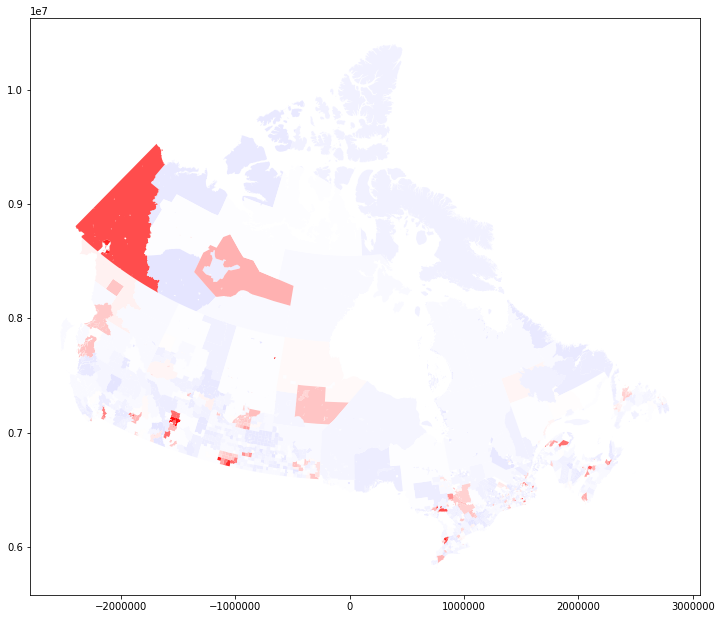

In [380]:
g = alaska[1].to_crs('+proj=lcc +lat_1=49 +lat_2=77 +lon_0=-91.52 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"').plot(column='color_value', vmin=-1, vmax=1, cmap='seismic', figsize=(12, 12))

In [381]:
%%time
canada = plot_map("canada")

CPU times: user 21.1 s, sys: 8.84 s, total: 30 s
Wall time: 30.8 s


In [382]:
canada[0].color_value.describe()

count    4240.000000
mean       -0.003182
std         0.051165
min        -0.064900
25%        -0.044816
50%        -0.017615
75%         0.032771
max         0.723828
Name: color_value, dtype: float64

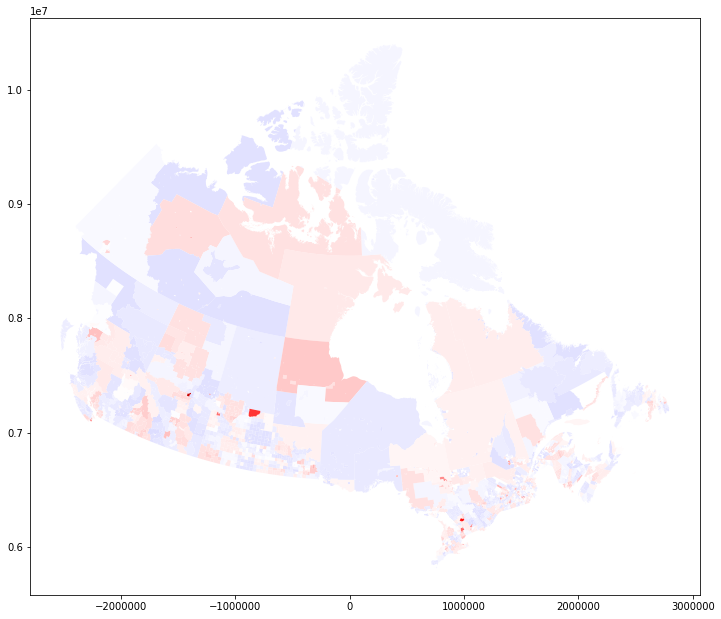

In [385]:
g = canada[1].to_crs('+proj=lcc +lat_1=49 +lat_2=77 +lon_0=-91.52 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"').plot(column='color_value', vmin=-1, vmax=1, cmap='seismic', figsize=(12, 12))

In [387]:
wifey = plot_map("wifey")

In [388]:
wifey[0].color_value.describe()

count    4240.000000
mean       -0.002913
std         0.042454
min        -0.059464
25%        -0.032998
50%        -0.010422
75%         0.036339
max         0.708771
Name: color_value, dtype: float64

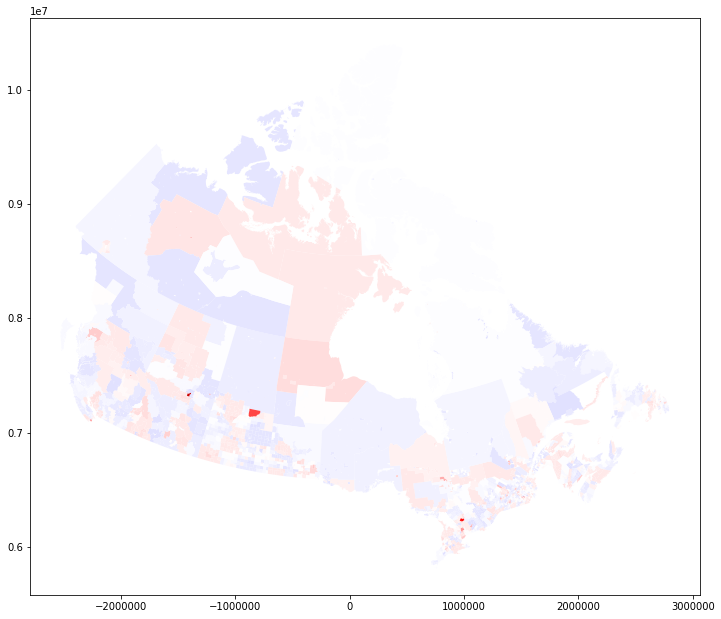

In [389]:
g = wifey[1].to_crs('+proj=lcc +lat_1=49 +lat_2=77 +lon_0=-91.52 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"').plot(column='color_value', vmin=-1, vmax=1, cmap='seismic', figsize=(12, 12))

In [390]:
leggings = plot_map("leggings")

In [391]:
leggings[0].color_value.describe()

count    4240.000000
mean       -0.005655
std         0.057164
min        -0.095779
25%        -0.049551
50%        -0.014630
75%         0.032064
max         0.831300
Name: color_value, dtype: float64

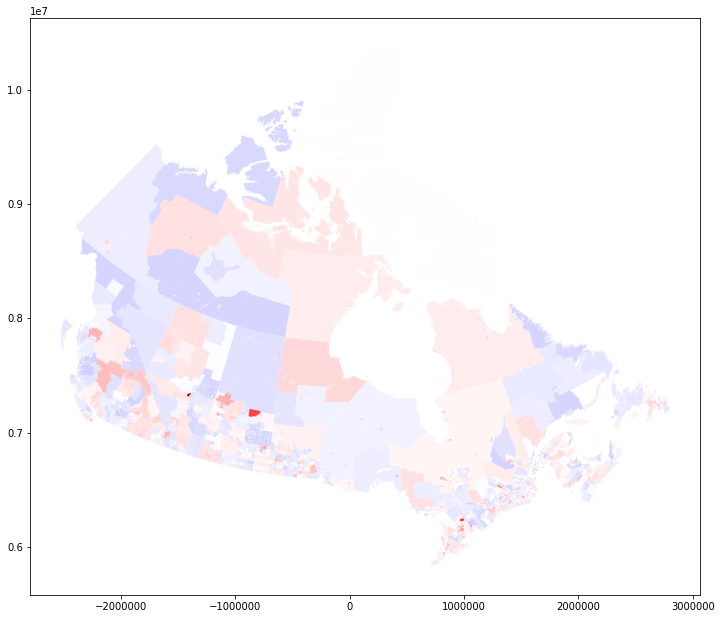

In [392]:
g = leggings[1].to_crs('+proj=lcc +lat_1=49 +lat_2=77 +lon_0=-91.52 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"').plot(column='color_value', vmin=-1, vmax=1, cmap='seismic', figsize=(12, 12))

In [404]:
kelowna = plot_map("kelowna")

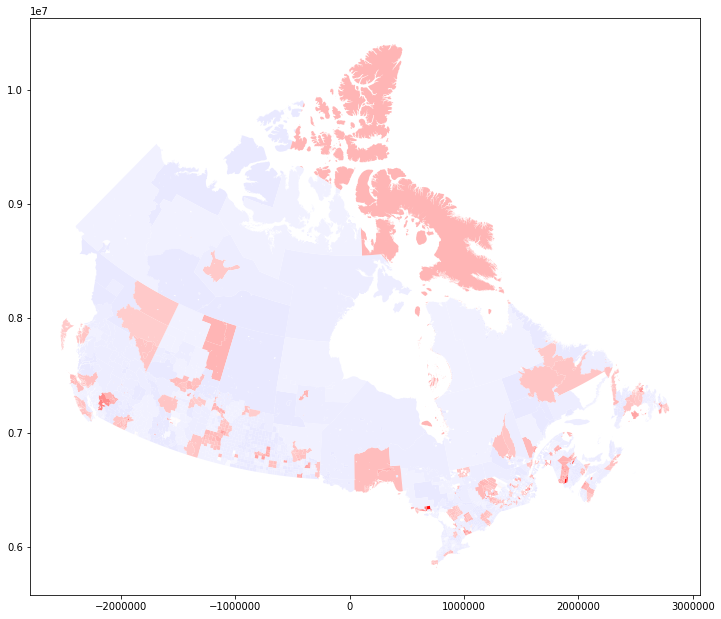

In [405]:
g = kelowna[1].to_crs('+proj=lcc +lat_1=49 +lat_2=77 +lon_0=-91.52 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"').plot(column='color_value', vmin=-0.5, vmax=0.5, cmap='seismic', figsize=(12, 12))

In [410]:
québec = plot_map("québec")

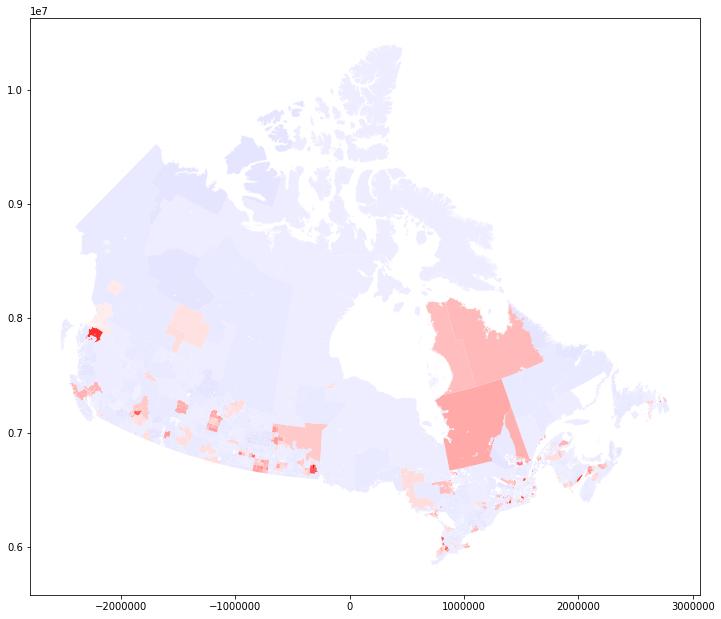

In [411]:
g = québec[1].to_crs('+proj=lcc +lat_1=49 +lat_2=77 +lon_0=-91.52 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"').plot(column='color_value', vmin=-0.5, vmax=0.5, cmap='seismic', figsize=(12, 12))

In [414]:
montreal = plot_map("montreal")

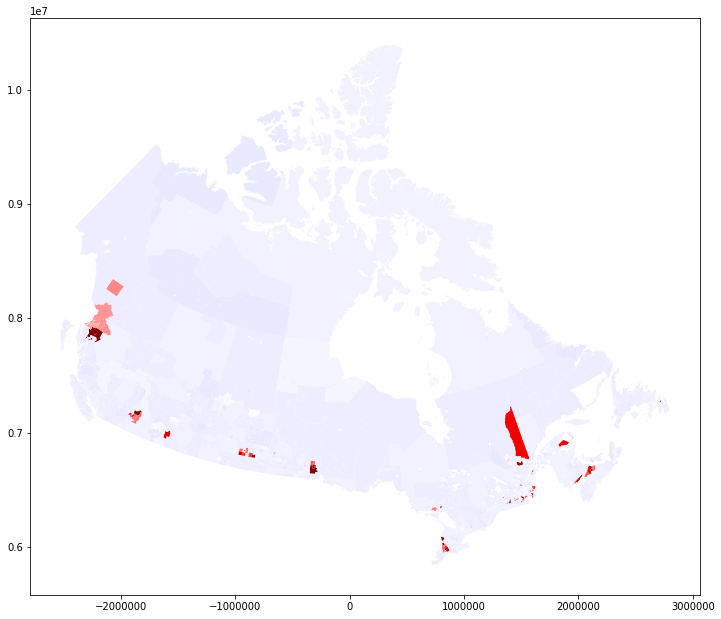

In [415]:
g = montreal[1].to_crs('+proj=lcc +lat_1=49 +lat_2=77 +lon_0=-91.52 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"').plot(column='color_value', vmin=-0.5, vmax=0.5, cmap='seismic', figsize=(12, 12))

## G* for all words

In [432]:
df_wc = pickle.load(open("word_count","rb"))

In [433]:
df_wc.head()

,a,a.m.,aa,aaa,aaron,ab,abandoned,abbey,abbotsford,abby,...,zero,zimmerman,zip,zoe,zombie,zombies,zone,zoo,zoom,zumba
2402047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5933019,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2426015,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2426010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1215011,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [455]:
from tqdm import tqdm_notebook as tqdm

In [456]:
%%time
G_star_lst = []
for i in tqdm(range(8200, 9100)):
    np.random.seed(12345)
    y = df_wc.iloc[:,i].astype("float64").values
    dist_w = weight
    lg = G_Local(y, dist_w, permutations=500, star = True)
    G_star_lst.append(lg.Zs)


CPU times: user 2h 12min 8s, sys: 40min 47s, total: 2h 52min 55s
Wall time: 3h 23min 16s


In [458]:
pickle.dump(G_star_lst, open("results8291.pkl","wb"))

In [478]:
file_lst = ["results20.pkl","results2045.pkl","results4548.pkl","results4851.pkl","results5157.pkl","results5762.pkl","results6272.pkl","results7282.pkl","results8291.pkl","results9100.pkl"]
results_lst = [pickle.load(open(file,"rb")) for file in file_lst]
results = list(itertools.chain.from_iterable(results_lst))

In [479]:
len(results)

10000

## PCA

In [481]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

results_t = np.transpose(results)
scaler = StandardScaler()
results_std = scaler.fit_transform(results_t)


In [488]:
pca = PCA(n_components=3)
scores = pca.fit_transform(results_std)
loadings = pca.components_

In [591]:
unique_words = df_wc.columns

In [613]:
unique_words[np.argsort(abs(loadings[2]))[-150:-100]]

Index(['dawson', 'nb', 'lollll', 'bagels', 'temps', 'integration',
       'motherfucking', 'latin', 'peel', 'elle', 'ds', 'circuit', 'moi',
       'inspector', 'handler', 'carey', 'vanier', 'dame', 'jai', 'mile',
       'oaks', 'il', 'jean', 'botanical', 'embassy', 'functional', 'metro',
       'vernon', 'dominion', 'forecast', 'admire', 'mon', 'apple', 'la',
       'pierre', 'bell', 'mont', 'café', 'subban', 'soleil', 'festivals',
       'chez', 'lolll', 'bon', 'molson', 'cirque', 'par', 'knights', 'petit',
       'ericsson'],
      dtype='object')

In [492]:
scores_df = pd.DataFrame(scores,columns=["PC1","PC2","PC3"],index=df_wc.index)

In [498]:
scores_df.head()

,PC1,PC2,PC3,CSDUID
2402047,-96.321023,4.514263,-5.361742,2402047
5933019,-96.041093,4.531509,-5.340854,5933019
2426015,-96.316559,4.513837,-5.357432,2426015
2426010,-96.115082,4.526209,-5.351497,2426010
1215011,-96.401364,4.570317,-5.366125,1215011


In [599]:
df_pc1 = pd.DataFrame(index=df_wc.index)
df_pc1["CSDUID"] = df_wc.index
df_pc1["color_value"] = np.zeros(4240)
df_pc1[["color_value"]] = RobustScaler().fit_transform(scores_df[["PC1"]])
df_pc1.color_value.describe()

count    4240.000000
mean        0.140264
std         0.650806
min        -0.674747
25%        -0.318266
50%         0.000000
75%         0.681734
max        11.072742
Name: color_value, dtype: float64

In [600]:
canada_df = gpd.GeoDataFrame.from_file("gcsd000b11a_e.shp")
canada_df = canada_df.merge(df_pc1, on='CSDUID')

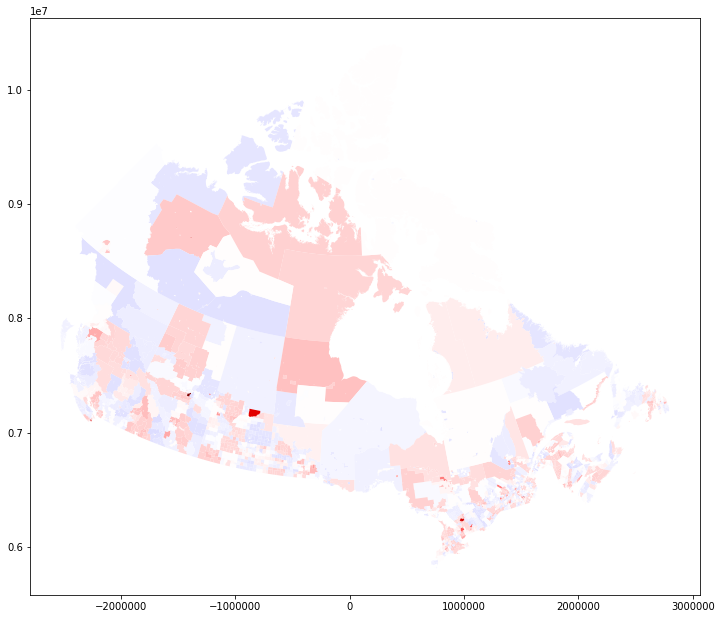

In [601]:
g = canada_df.to_crs('+proj=lcc +lat_1=49 +lat_2=77 +lon_0=-91.52 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"').plot(column='color_value', vmin=-10, vmax=10, cmap='seismic', figsize=(12, 12))

In [602]:
from sklearn.preprocessing import RobustScaler
df_pc2 = pd.DataFrame(index=df_wc.index)
df_pc2["CSDUID"] = df_wc.index
df_pc2["color_value"] = np.zeros(4240)
df_pc2[["color_value"]] = RobustScaler().fit_transform(scores_df[["PC2"]])
df_pc2.color_value.describe()

count    4240.000000
mean       -0.269997
std         1.497799
min       -15.631064
25%        -0.760660
50%         0.000000
75%         0.239340
max        36.774995
Name: color_value, dtype: float64

In [603]:
canada_df = gpd.GeoDataFrame.from_file("gcsd000b11a_e.shp")
canada_df = canada_df.merge(df_pc2, on='CSDUID')

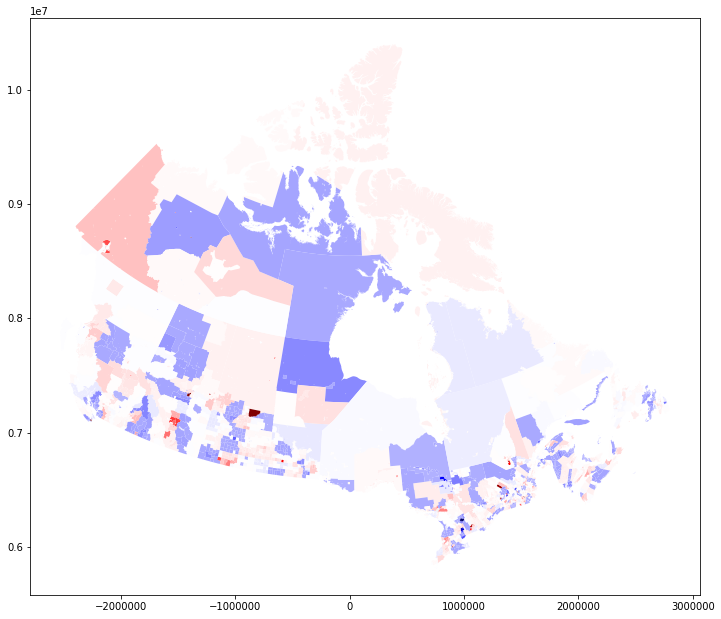

In [604]:
g = canada_df.to_crs('+proj=lcc +lat_1=49 +lat_2=77 +lon_0=-91.52 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"').plot(column='color_value', vmin=-10, vmax=10, cmap='seismic', figsize=(12, 12))

In [593]:
from sklearn.preprocessing import RobustScaler
df_pc3 = pd.DataFrame(index=df_wc.index)
df_pc3["CSDUID"] = df_wc.index
df_pc3["color_value"] = np.zeros(4240)
df_pc3[["color_value"]] = RobustScaler().fit_transform(scores_df[["PC3"]])

In [595]:
df_pc3.color_value.describe()

count    4240.000000
mean        0.652175
std         2.914167
min       -28.103163
25%        -0.319018
50%         0.000000
75%         0.680982
max        36.217552
Name: color_value, dtype: float64

In [596]:
canada_df = gpd.GeoDataFrame.from_file("gcsd000b11a_e.shp")
canada_df = canada_df.merge(df_pc3, on='CSDUID')

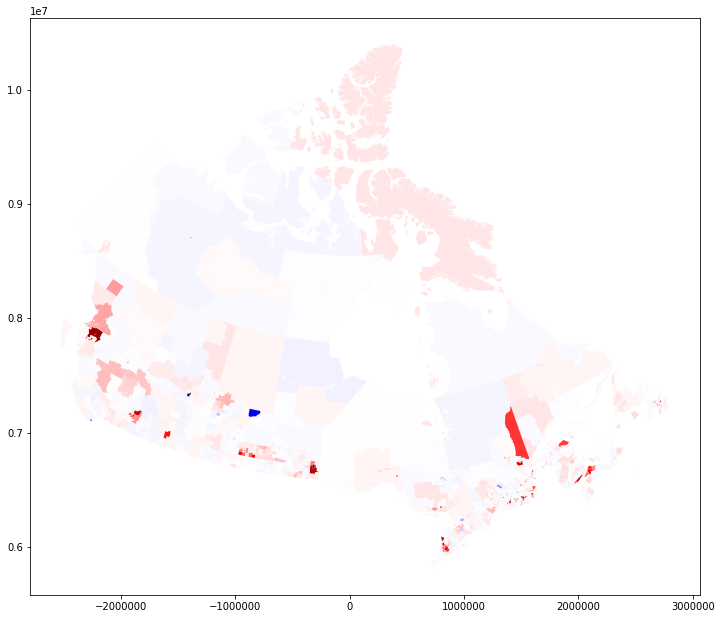

In [598]:
g = canada_df.to_crs('+proj=lcc +lat_1=49 +lat_2=77 +lon_0=-91.52 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"').plot(column='color_value', vmin=-30, vmax=30, cmap='seismic', figsize=(12, 12))